In [20]:
pip install sklearn

  Using cached sklearn-0.0.post5-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,  roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [78]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [83]:
train = pd.read_pickle('./feature/feat_v1.pkl')
train


,word_count,pub_time,abstract_len,headline_len,len_lead,n_comment,is_popular,is_noon,is_weekday,group_by_news_desk,feature_news_desk,group_by_section_name,feature_section_name,group_by_subsection_name,feature_subsection_name,group_by_type_of_material,feature_type_of_material,is_party,is_congress,is_president,is_ukrainian_russian_war,is_storm,is_spell,is_crossword,is_game,sentiment_tb_polar_abs,sentiment_tb_subj,sentiment_vader_pos,sentiment_vader_compound,sentiment_snow_pos,sentiment_abstract_tb_polar,sentiment_abstract_tb_polar_abs,sentiment_abstract_tb_subj,sentiment_abstract_tb_pos,sentiment_abstract_vader_neu,sentiment_abstract_vader_pos,sentiment_abstract_vader_compound,sentiment_abstract_snow,sentiment_abstract_snow_abs,sentiment_abstract_snow_pos
0,882,0,8,5,54,854,1,0,1,0.517656,0.5,0.465813,0.5,NaN,NaN,0.519849,0.5,0,0,1,0,0,0,0,0,0.083333,0.583333,0.382,0.2960,0,0.000000,0.000000,0.000000,0,0.680,0.320,0.5106,0.421875,0.156251,0
1,263,0,51,9,51,0,0,0,1,0.110032,0.1,0.216640,0.2,NaN,NaN,0.331848,0.3,0,0,0,0,0,0,0,0,0.318182,0.500000,0.478,0.6705,0,0.418182,0.418182,0.527273,1,0.863,0.137,0.7311,0.071555,0.856889,0
2,695,1,29,10,14,0,0,0,1,0.265251,0.3,0.216640,0.2,0.266902,0.3,0.331848,0.3,1,1,1,0,0,0,0,0,0.000000,0.000000,0.256,0.3612,0,0.000000,0.000000,0.000000,0,0.909,0.000,-0.4019,0.119674,0.760653,0
3,438,1,39,6,39,0,0,0,1,0.200885,0.2,0.198759,0.2,NaN,NaN,0.331848,0.3,0,0,0,0,0,0,0,0,0.000000,0.000000,0.231,0.0516,0,-0.107576,0.107576,0.613636,0,0.801,0.114,0.0772,0.019362,0.961277,0
4,190,3,17,8,53,0,0,0,1,0.234586,0.2,0.216640,0.2,NaN,NaN,0.331848,0.3,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000,0.0000,0,0.136364,0.136364,0.454545,1,0.714,0.201,0.4215,0.017767,0.964465,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63223,1169,19,16,9,22,0,0,0,0,0.517656,0.5,0.465813,0.5,NaN,NaN,0.519849,0.5,0,0,0,0,0,0,0,0,0.000000,1.000000,0.000,0.0000,0,0.000000,0.000000,0.000000,0,0.888,0.112,0.2235,0.396490,0.207019,0
63224,530,19,24,8,27,0,0,0,0,0.110032,0.1,0.216640,0.2,NaN,NaN,0.331848,0.3,0,0,0,0,0,0,0,0,0.125000,1.000000,0.000,0.0000,0,-0.122222,0.122222,0.188889,0,1.000,0.000,0.0000,0.121190,0.757621,0
63225,1163,20,26,10,13,0,0,0,0,0.343691,0.3,0.309276,0.3,0.452572,0.5,0.331848,0.3,0,0,0,0,0,0,0,0,0.250000,1.000000,0.470,0.7351,0,-0.100000,0.100000,0.783333,0,0.807,0.091,-0.0772,0.110442,0.779117,0
63226,653,20,15,9,29,0,0,0,0,0.110032,0.1,0.216640,0.2,NaN,NaN,0.331848,0.3,0,0,0,0,0,0,0,0,0.300000,0.900000,0.000,0.0000,0,0.000000,0.000000,0.000000,0,1.000,0.000,0.0000,0.189069,0.621863,0


In [84]:

X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X
y


0        1
1        0
2        0
3        0
4        0
        ..
63223    0
63224    0
63225    0
63226    0
63227    0
Name: is_popular, Length: 63228, dtype: int64

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
feature_names = X_train.columns

In [87]:
models = {'rf': RandomForestClassifier(random_state=42),
          'xgb': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc')}

c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [88]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [89]:
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [21]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999143583927594,
 'test_auc': 0.8459441627387693,
 'precision': 0.7375669472073451,
 'specificity': 0.91921808761187,
 'recall': 0.5391498881431768,
 'f_score': 0.6229402261712439}

True Negatives: 3903
False Positives: 343
False Negatives: 824
True Positives: 964


In [90]:
xgb = run_model('xgb')

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9445394233524427,
 'test_auc': 0.8819288813429236,
 'precision': 0.7268457636671051,
 'specificity': 0.8883513783306458,
 'recall': 0.6506895391860074,
 'f_score': 0.6866625255124679}

True Negatives: 11569
False Positives: 1454
False Negatives: 2077
True Positives: 3869


In [91]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,0.944539,0.881929,0.726846,0.888351,0.65069,0.686663


In [10]:
svc_params = {
    'svc__C':[0.05, 1, 0.04, 0.06, 0.045, 0.9, 0.8, 0.7, 0.6],
    'svc__gamma':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.04, 0.03, 0.02], 
    'svc__kernel':['rbf', 'sigmoid'],
}
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [11]:
svc_params = {
    'svc__C':[0.6],
    'svc__gamma':[0.02], 
    'svc__kernel':['rbf', 'sigmoid'],
}
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
### BEST PARAMS ###


SVC(C=0.6, gamma=0.02, probability=True, random_state=42)

### METRICS ###


{'model': 'svc',
 'train_auc': 0.8481786379916619,
 'test_auc': 0.8087070499830871,
 'precision': 0.7688123300090662,
 'specificity': 0.9399434762129063,
 'recall': 0.4742729306487696,
 'f_score': 0.5866482186094777}

True Negatives: 3991
False Positives: 255
False Negatives: 940
True Positives: 848


In [12]:
rf_params = {'rf__n_estimators': [100, 200, 300, 400, 500],
             'rf__max_depth': [10, 20, 30, 40, 50, 60],
             'rf__min_samples_leaf': [i for i in range(2, 18)],
            }
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)
joblib.dump(rf_gs[1], "./model/rf_v1.joblib")

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9711480701164776,
 'test_auc': 0.8525750910713702,
 'precision': 0.7425515660809778,
 'specificity': 0.9206311822892134,
 'recall': 0.5436241610738255,
 'f_score': 0.6277042298999032}

True Negatives: 3909
False Positives: 337
False Negatives: 816
True Positives: 972


In [45]:
xgb_depth = {'xgb__max_depth': [1, 3, 5, 7]}
xgb_gamma = {'xgb__max_depth' : [3],'xgb__gamma': np.linspace(0, 3, 20)}
xgb_reg = {'xgb__max_depth' : [3], 'xgb__gamma' : [2.3684210526315788],'xgb__reg_alpha': np.linspace(0, 3, 6),
           'xgb__reg_lambda': np.linspace(0, 3, 6)}
xgb_learning = {'xgb__max_depth' : [3], 'xgb__gamma' : np.linspace(0, 0.5, 10),'xgb__learning_rate': np.linspace(0.05, 0.3, 20),
                'xgb__n_estimators': [200]}

In [93]:
xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], #0.1
              'xgb__max_depth' : [3, 5], #5
              'xgb__n_estimators' : [100, 200, 300], #300
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], #1.0
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], #1.0
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], #2.5
            }

In [96]:
xgb_params = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [1.0], 
              'xgb__gamma' : [2.5],
            }

In [97]:

xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)
#xgb_gs[1].save_model('./model/xgb_v1.json')

c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9225078726361484,
 'test_auc': 0.8847406677502627,
 'precision': 0.7348139711465452,
 'specificity': 0.8927282500191968,
 'recall': 0.6510258997645476,
 'f_score': 0.6903870162297129}

True Negatives: 11626
False Positives: 1397
False Negatives: 2075
True Positives: 3871


In [59]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
5,xgb,0.899767,0.850782,0.741204,0.922044,0.530201,0.618194
11,xgb,0.895781,0.849595,0.745083,0.923693,0.529642,0.619157
10,xgb,0.891050,0.849510,0.749611,0.924164,0.539150,0.627196
2,xgb,0.885209,0.848274,0.738168,0.919218,0.540828,0.624274
1,xgb,0.887357,0.847804,0.736638,0.919925,0.531879,0.617733
7,xgb,0.886672,0.847360,0.737165,0.919218,0.538031,0.622050
9,xgb,0.903674,0.847220,0.741093,0.922986,0.523490,0.613569
6,xgb,0.873067,0.846930,0.739464,0.919925,0.539709,0.623990
0,xgb,0.893111,0.846908,0.733591,0.918747,0.531320,0.616283
3,xgb,0.868729,0.845972,0.739431,0.920160,0.538031,0.622855


In [98]:
gs_dict = {
    xgb_gs: 'XGBoostClassifier',
    #rf_gs: 'RandomForest',
}

In [99]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = sklearn.metrics.RocCurveDisplay.from_estimator(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

In [100]:
print(sklearn.__version__)

1.0.2


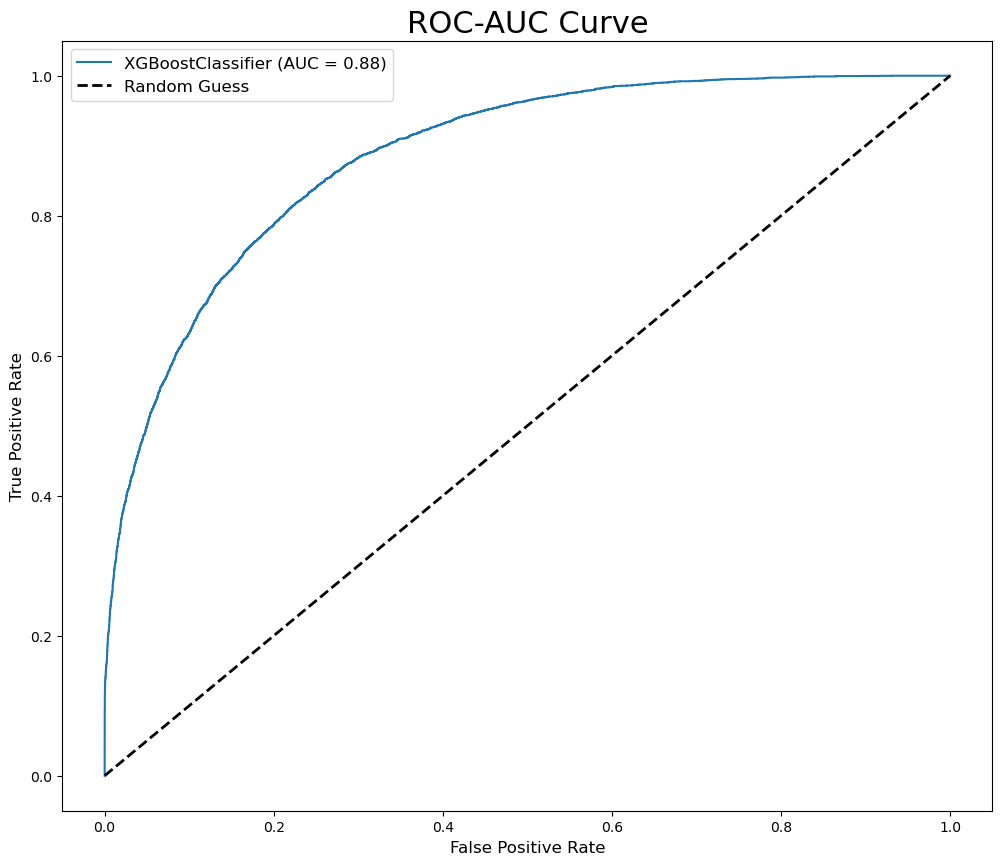

In [101]:
roc_curve_plotter(gs_dict, True)

In [113]:
test = pd.read_pickle('./feature/feat_test_v1.pkl')
test = test._get_numeric_data()

In [114]:
final_actual = test['is_popular']

In [115]:
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])


In [116]:
def evaluate_model(model):
    final_proba = model.predict_proba(test)
    final_proba = final_proba[:, 1]
    final_preds = model.predict(test)
    print(f'Accuracy:', f'{accuracy_score(final_actual, final_preds):.3f}')
    print(f'Precision:', f'{precision_score(final_actual, final_preds):.3f}')
    print(f'Recall:', f'{recall_score(final_actual, final_preds):.3f}')
    print(f'ROC-AUC:', f'{roc_auc_score(final_actual, final_proba):.3f}')

In [117]:
evaluate_model(xgb_gs)

Accuracy: 0.814
Precision: 0.754
Recall: 0.612
ROC-AUC: 0.882


In [55]:

evaluate_model(rf_gs)

Accuracy: 0.867
Precision: 0.861
Recall: 0.666
ROC-AUC: 0.935


In [57]:
evaluate_model(svc_gs)

Accuracy: 0.807
Precision: 0.792
Recall: 0.487
ROC-AUC: 0.836


In [108]:
xgb_gs.fit(X, y)
#rf_gs.fit(X, y)

Pipeline(steps=[('ss',
                 <__main__.CustomTransformer object at 0x00000271600E70D0>),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=2.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               m

In [109]:
evaluate_model(xgb_gs)

Accuracy: 0.849
Precision: 0.815
Recall: 0.681
ROC-AUC: 0.917


In [61]:
evaluate_model(rf_gs)

Accuracy: 0.896
Precision: 0.912
Recall: 0.724
ROC-AUC: 0.970


In [62]:
final_proba = rf_gs.predict_proba(test)
final_proba = final_proba[:, 1]
final_preds = rf_gs.predict(test)

In [63]:
predictions = pd.DataFrame(data=[final_actual, final_preds, final_proba]).T
predictions.columns = ['actual', 'predicted', 'proba']

In [64]:
predictions

,actual,predicted,proba
0,1.0,1.0,0.936039
7674,1.0,0.0,0.129437
7680,1.0,0.0,0.171522
7688,1.0,0.0,0.035383
7710,1.0,1.0,0.695174
...,...,...,...
18044,0.0,0.0,0.433493
16621,0.0,0.0,0.049346
9178,0.0,0.0,0.246092
18081,0.0,0.0,0.014328


In [65]:
wrong_predictions = predictions[predictions['actual'] != predictions['predicted']]

In [70]:
init_test = pd.read_pickle('./nytimes-dataset/test.pkl').reset_index(drop=True)

In [71]:
wrong_predictions = pd.merge(wrong_predictions, init_test, left_index=True, right_index=True)

In [72]:
wrong_predictions = wrong_predictions[['actual', 'predicted', 'proba', 'news_desk', 'section_name', 'subsection_name',
                                       'headline', 'abstract', 'keywords']]

In [73]:
wrong_predictions['actual'].value_counts()

actual
1.0    4630
0.0    3379
Name: count, dtype: int64

In [74]:
wrong_predictions[wrong_predictions['proba'] > 0.80].head(10).sort_values(by='proba', ascending=False)

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
2096,0.0,1.0,0.970452,U.S.,U.S.,NaN,"Perkins County, Nebraska Covid Case and Risk Tracker","See the latest charts and maps of coronavirus cases, deaths and hospitalizations in Perkins County, Nebraska","[Coronavirus (2019-nCoV), States (US), Deaths (Fatalities), United States, Disease Rates]"
2188,0.0,1.0,0.957031,Washington,U.S.,Politics,Biden Administration Reviewing Trump Arms Sales to U.A.E. and Saudi Arabia,"Officials called the review standard for a new administration, but many Democrats critical of the Gulf States want t...","[Biden, Joseph R Jr, Arms Trade, Blinken, Antony J, State Department, United States International Relations, United ..."
2137,0.0,1.0,0.931082,U.S.,U.S.,NaN,"Bernalillo County, New Mexico Covid Case and Risk Tracker","See the latest charts and maps of coronavirus cases, deaths and hospitalizations in Bernalillo County, New Mexico","[Coronavirus (2019-nCoV), States (US), Deaths (Fatalities), United States, Disease Rates]"
2040,0.0,1.0,0.897194,U.S.,U.S.,NaN,"New Madrid County, Missouri Covid Case and Risk Tracker","See the latest charts and maps of coronavirus cases, deaths and hospitalizations in the Sikeston area","[Coronavirus (2019-nCoV), States (US), Deaths (Fatalities), United States, Disease Rates]"
2041,0.0,1.0,0.849264,U.S.,U.S.,NaN,"Newton County, Missouri Covid Case and Risk Tracker","See the latest charts and maps of coronavirus cases, deaths and hospitalizations in the Joplin area","[Coronavirus (2019-nCoV), States (US), Deaths (Fatalities), United States, Disease Rates]"
2268,0.0,1.0,0.847374,BookReview,Books,Book Review,Mystery Boxes and Budding Loves: New Science Fiction and Fantasy,"“The Absolute Book,” by Elizabeth Knox, takes on a number of genres, while “Winter’s Orbit,” by Everina Maxwell, sta...","[Books and Literature, The Absolute Book (Book), Winter's Orbit (Book), Knox, Elizabeth, Maxwell, Everina]"
17927,0.0,1.0,0.836219,Culture,Movies,NaN,Peter Dinklage on ‘Cyrano’ and Life After ‘Game of Thrones’,The actor is happy to upend 100 years of clichés by playing the romantic lead. It’s a liberating change after the se...,"[Movies, Actors and Actresses, Content Type: Personal Profile, Dinklage, Peter, Cyrano (Movie), Game of Thrones (TV ..."
2115,0.0,1.0,0.834796,U.S.,U.S.,NaN,"Lincoln County, Nevada Covid Case and Risk Tracker","See the latest charts and maps of coronavirus cases, deaths and hospitalizations in Lincoln County, Nevada","[Coronavirus (2019-nCoV), States (US), Deaths (Fatalities), United States, Disease Rates]"
2207,0.0,1.0,0.826982,Foreign,World,NaN,Check this out to get your every Covid-19 vaccine question answered. Really.,"The Well section set out to answer some of the most commonly asked questions about the coronavirus vaccine, and a fe...",[internal-essential]
5169,0.0,1.0,0.816430,OpEd,Opinion,NaN,"A Top G.O.P. Pollster on Trump 2024, QAnon and What Republicans Really Want",Kristen Soltis Anderson has done some of the most in-depth surveys of the party’s voters to date. Her findings are u...,"[Polls and Public Opinion, Anderson, Kristen Soltis (1984- ), Republican Party, United States Politics and Governmen..."


In [75]:
wrong_predictions[wrong_predictions['proba'] < 0.4].head(10).sort_values(by='proba')

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
7688,1.0,0.0,0.035383,Foreign,World,Middle East,Fighting rages overnight after Biden voices support for a cease-fire.,"The president’s statement, following a call with Prime Minister Benjamin Netanyahu of Israel, fell short of an immed...","[Biden, Joseph R Jr, Netanyahu, Benjamin, Gaza Strip, Israel, War and Armed Conflicts]"
7776,1.0,0.0,0.045524,OpEd,Opinion,NaN,This Moment Is Different,"The Palestinian people are moving on, whether or not their leaders are with them.","[Palestinians, United States International Relations, Peace Process, Israel]"
7742,1.0,0.0,0.078546,OpEd,Opinion,NaN,My Father Was in a Coma for 57 Days. He Awoke to a Pandemic.,"In this short film, the family of one of Spain’s earliest Covid-19 patients chronicles his battle.","[Documentary Films and Programs, Spain, Madrid (Spain), Coronavirus (2019-nCoV)]"
7674,1.0,0.0,0.129437,OpEd,Opinion,NaN,So … When Should I Wear a Mask Now?,Three experts respond to questions from readers about face masks.,"[Coronavirus Risks and Safety Concerns, Content Type: Service, Masks, Coronavirus (2019-nCoV)]"
7733,1.0,0.0,0.156361,Business,Technology,NaN,Apple’s Bargain in China,Apple touts its commitment to privacy and free speech. That’s why its China operation is so striking.,"[Apple Inc, China, Politics and Government, Censorship, Surveillance of Citizens by Government, Computers and the In..."
7680,1.0,0.0,0.171522,Foreign,World,Europe,What Drove the Israel-Gaza Conflict? Here’s What You Need to Know.,"After 11 days of intense fighting, Hamas and Israel began a cease-fire. Here is the arc of the conflict.","[Israel, Palestinians, Defense and Military Forces, Hamas, War and Armed Conflicts, Civilian Casualties, Gaza Strip,..."
7765,1.0,0.0,0.208679,Learning,The Learning Network,NaN,Teaching About the Current Conflict in Gaza and Israel,"In this lesson, students will learn about the roots, causes and impact of the escalating violence in Israel and the ...",[]
7721,1.0,0.0,0.279530,Foreign,World,Middle East,"An Israeli airstrike damaged Gaza’s only lab for processing coronavirus tests, officials said.",Health officials suspended coronavirus screening. Experts have warned that the conflict with Israel could worsen the...,"[Gaza Strip, Israel, Coronavirus (2019-nCoV), War and Armed Conflicts, Vaccination and Immunization]"
7762,1.0,0.0,0.376633,Sports,Sports,Golf,"Rory McIlroy, With a New Coach and Returning Galleries, Has Rebounded","His world ranking dropped to as low as 13th this spring. But coming off a victory, McIlroy has returned to the Ocean...","[PGA Championship, Golf, Kiawah Island Golf Resort, PGA Tour Inc, McIlroy, Rory, Content Type: Personal Profile]"
7746,1.0,0.0,0.381998,Dining,Food,NaN,Daniel Boulud’s Le Pavillon Opens,"An automated dumpling shop in the East Village, a pivot for Gabriel Stulman’s The Jones space, and more restaurant n...","[Restaurants, Le Pavillon (Manhattan, NY, Restaurant), Boulud, Daniel, Manhattan (NYC)]"


In [ ]:
#correct analy

In [76]:
predictions = pd.merge(predictions, init_test, left_index=True, right_index=True)

In [78]:
predictions = predictions[['actual', 'predicted', 'proba', 'news_desk', 'section_name', 'subsection_name',
                                       'headline', 'abstract', 'keywords']]

In [79]:
predictions.sort_values(by='proba', ascending=False).head(5)

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
636,1.0,1.0,0.990551,Learning,The Learning Network,NaN,Word + Quiz: intransigence,This word has appeared in 35 articles on NYTimes.com in the past year.,[]
467,0.0,1.0,0.989730,Foreign,World,Asia Pacific,"A Quarantine Nightmare: Three Weeks in a Hotel, if You Can Find One","Hong Kong’s abrupt new entry requirement — which has shaken travelers, domestic workers, airlines and hotels alike —...","[Hong Kong, Quarantines, Hotels and Travel Lodgings, Domestic Service, Politics and Government]"
1274,0.0,1.0,0.989401,Business,Business Day,NaN,The Bond film ‘No Time to Die’ is delayed again as the virus stymies Hollywood.,The postponement until Oct. 8 is the surest sign yet that Hollywood does not believe the masses will be ready to ret...,"[Movies, No Time to Die (Movie), Bond, James (Fictional Character), Coronavirus (2019-nCoV), Quarantine (Life and Cu..."
494,0.0,1.0,0.988954,Washington,U.S.,Politics,"Trump, finally conceding to reality, says transition will be peaceful. Democrats say he must be removed now.",President Trump seemed to surrender his ferocious effort to hang onto power after Congress formally accepted the vic...,[]
283,1.0,1.0,0.988928,U.S.,U.S.,Elections,Kentucky Election Results: Fifth Congressional District,See full results and maps from the Kentucky election.,"[Elections, Presidential Election of 2020, United States, internal-election-open, House of Representatives, Kentucky]"


In [80]:
predictions.sort_values(by='proba', ascending=False).tail(5)

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
3719,0.0,0.0,0.000251,Foreign,World,NaN,Canada authorizes the AstraZeneca vaccine.,The addition of a third vaccine may ease the country’s growing dissatisfaction about the sluggish pace of vaccinations.,"[internal-essential, Coronavirus (2019-nCoV), Canada, AstraZeneca PLC, Vaccination and Immunization]"
12071,0.0,0.0,0.000212,Games,Crosswords & Games,NaN,In the ‘Midnight Zone’,"Oliver Roeder, a longtime member of the puzzle community, makes his New York Times Crossword debut.",[Crossword Puzzles]
17030,0.0,0.0,0.000186,SpecialSections,Climate,NaN,Europe Met a Climate Target. But Is It Burning Less Carbon?,The European Union promised to reduce its emissions 20 percent by 2020. Did it happen?,"[Greenhouse Gas Emissions, United Nations Framework Convention on Climate Change, Global Warming, Alternative and Re..."
11261,0.0,0.0,0.000038,Sports,Sports,Olympics,"Jasmine Camacho-Quinn wins the 100-meter hurdles, Puerto Rico’s first gold in track.",It’s also Puerto Rico’s second Olympic gold medal in any sport.,[Olympic Games (2020)]
20112,0.0,NaN,NaN,Foreign,World,Europe,Ukraine’s President Tries to Avert Panic as Pressure Mounts,"With Ukraine at the center of Europe’s most intense security crisis of the post-Cold War era, President Zelensky is ...","[Zelensky, Volodymyr, Kyiv (Ukraine), Putin, Vladimir V, War and Armed Conflicts, Russia, Ukraine, Politics and Gove..."


<Axes: >

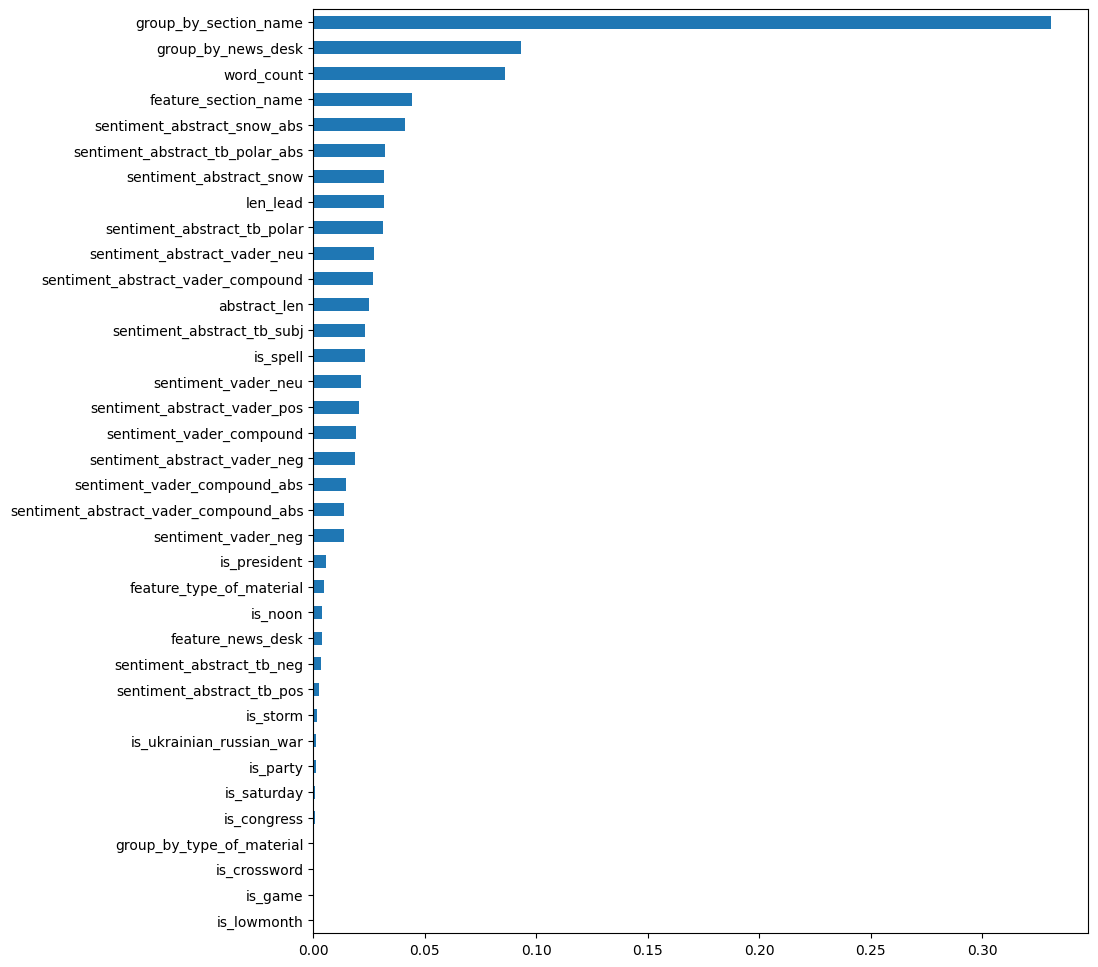

In [81]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

In [82]:

scores_dict = xgb_gs.steps[1][1]._Booster.get_score(importance_type='gain')

In [83]:
total_cover = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)

In [84]:
total_gain = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)

In [85]:
gain_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)

In [86]:
weight_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)

In [87]:
cover_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

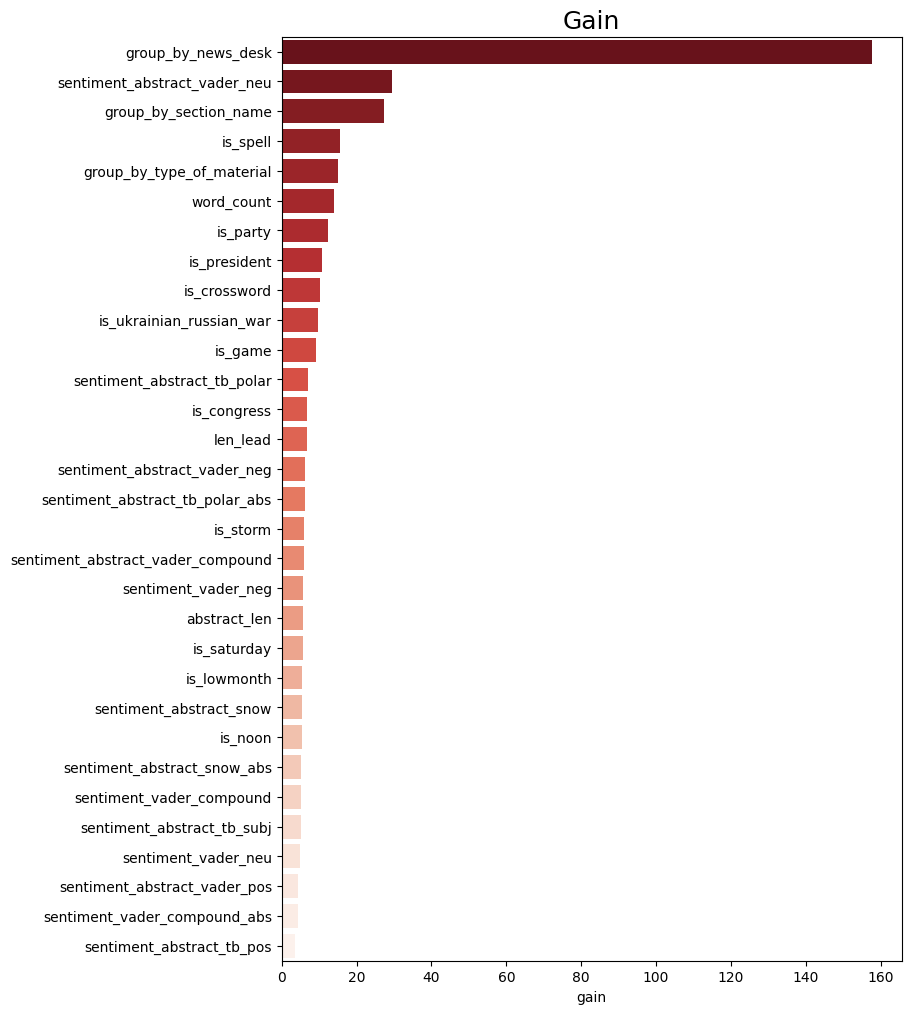

In [88]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

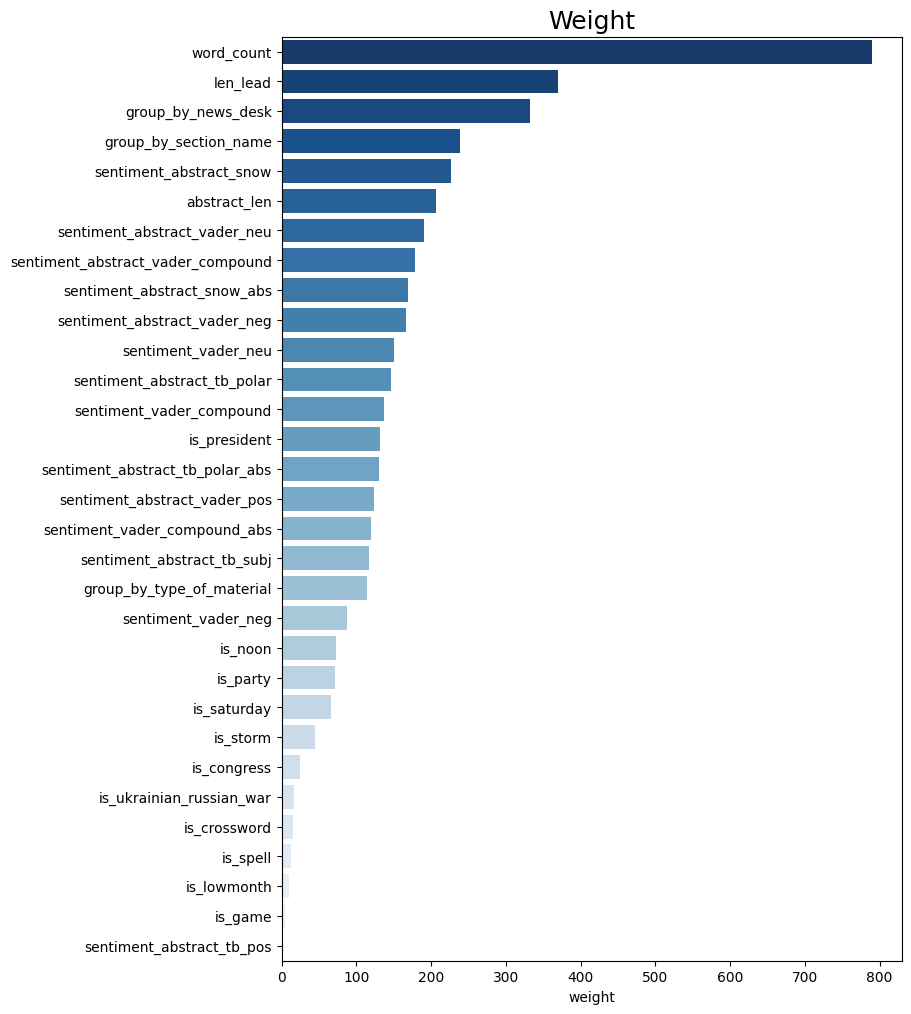

In [89]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

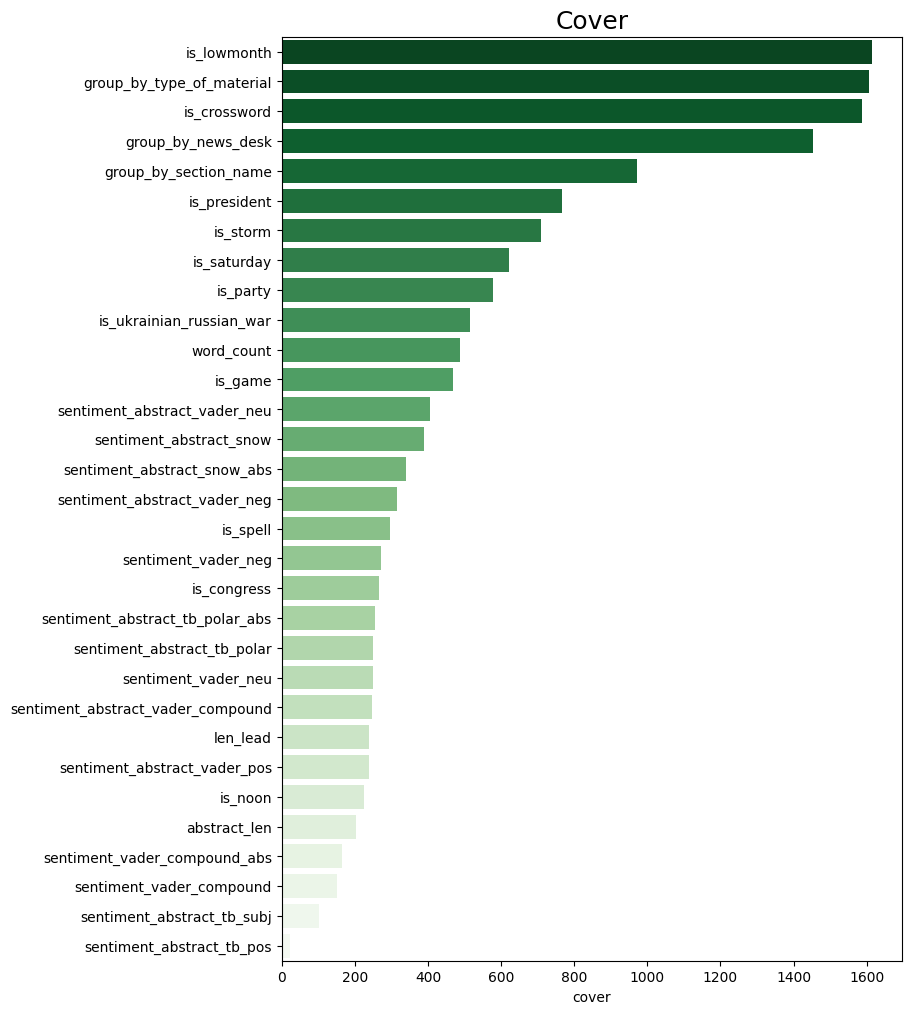

In [90]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

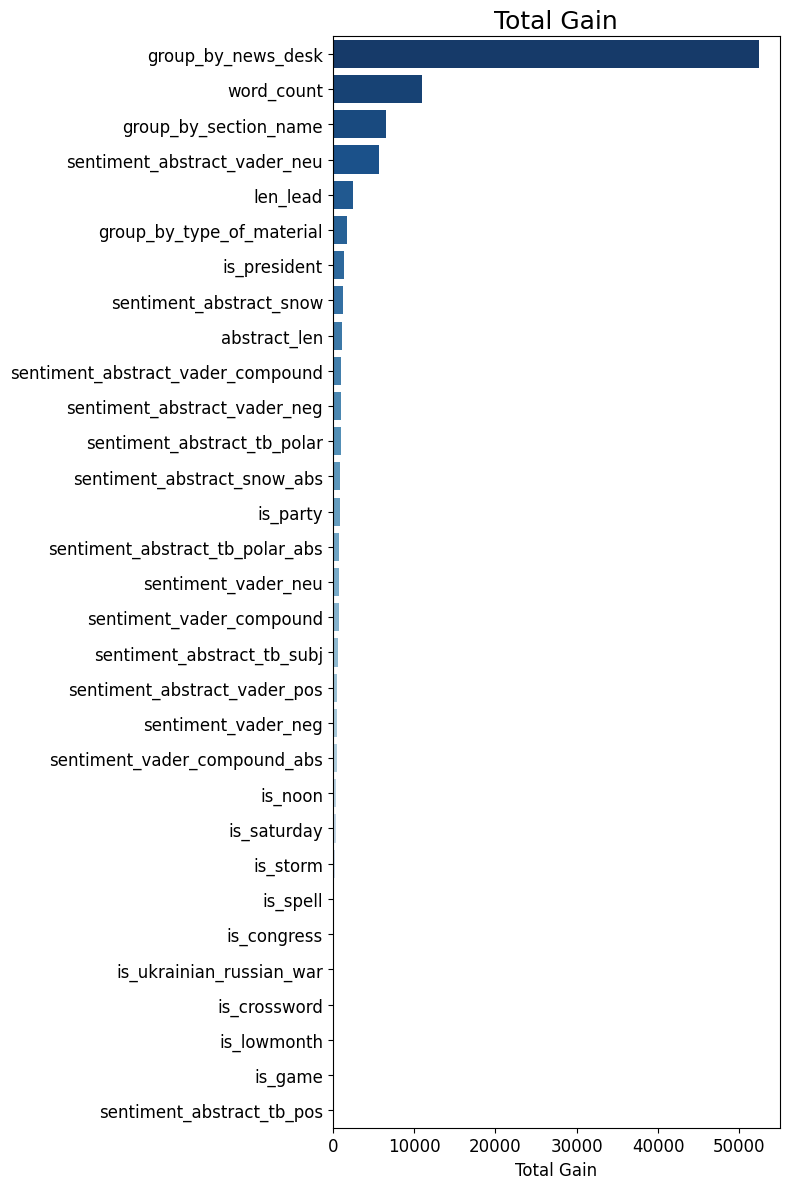

In [91]:

plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

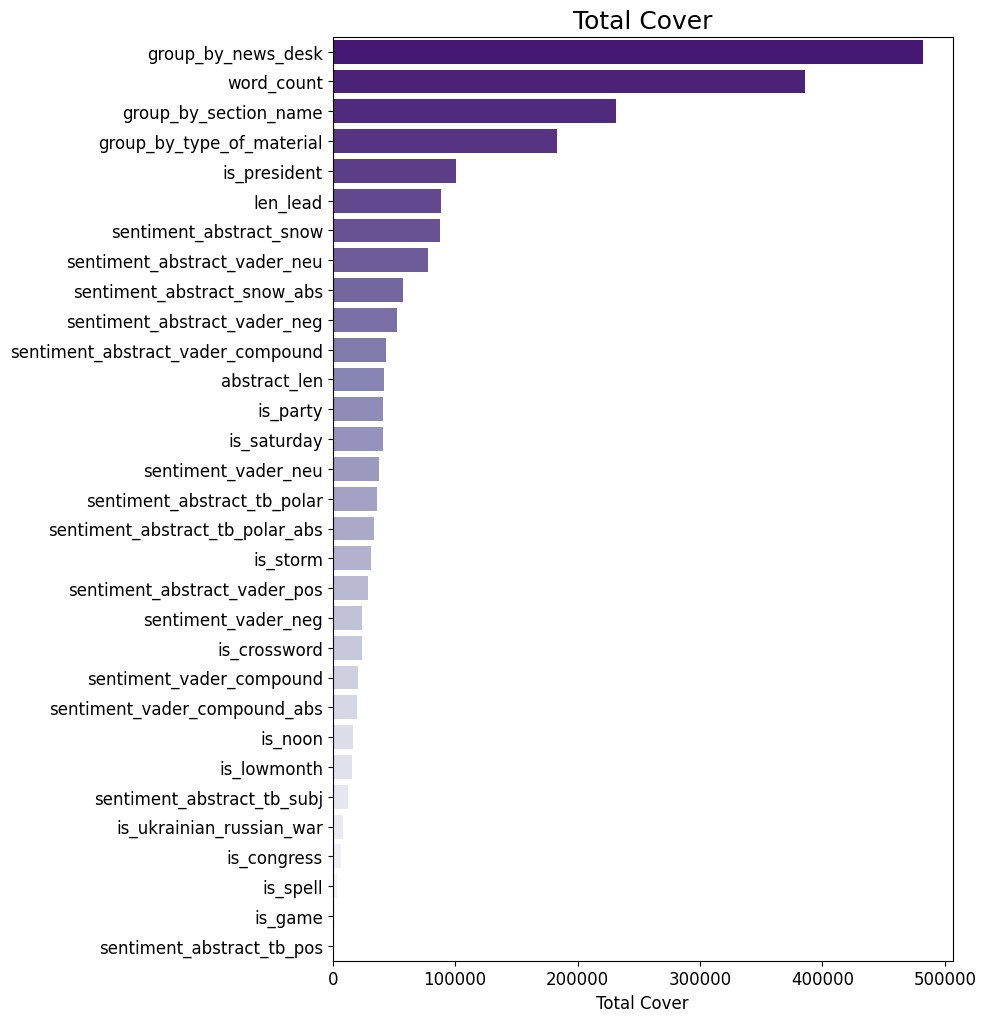

In [92]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);